In [1]:
'''
Model default parameters
'''
import random
import numpy as np

M = 4 # Number of Spiking motifs
N = 20 # Number of input neurons
D = 71 # temporal depth of receptive field
T = 1000
nrn_fr = 15 # hz
pg_fr = 6 # hz
background_noise_fr = 10 # h
seed=41
np.random.seed(seed)

In [2]:
default_params = {
    'M':M,
    'N':N,
    'D':D,
    'T':T,
    'nrn_fr':nrn_fr,
    'pg_fr':pg_fr,
    'background_noise_fr':background_noise_fr,
    'seed':seed
}
scan_dict = {
    'M':[1,2,4,8,16,32,64,128],
    'N':[5,10,15,20,40,80,160,200],
    'D':[5,11,21,31,51,71,101,151,201],
    'T':[500,1000,1500,2000,5000],
    'nrn_fr':[5,10,15,20,25,35,50],
    'pg_fr':[4,5,8,10,15,20],
    'background_noise_fr':[0,2.5,5,7.5,10,12.5,15,20]
}

In [3]:
'''
Setup
'''

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import sys
np.set_printoptions(threshold=sys.maxsize)
disp_figs = True
import colorsys

def create_color_spectrum(num_labels):
    golden_ratio_conjugate = 0.618033988749895
    hues = np.arange(num_labels)
    hues = (hues * golden_ratio_conjugate) % 1.0
    saturations = np.ones(num_labels) * 0.8
    lightness = np.ones(num_labels) * 0.6

    # Convert HSL to RGB and then to hexadecimal
    colors = []
    for h, s, l in zip(hues, saturations, lightness):
        r, g, b = [int(255 * x) for x in colorsys.hls_to_rgb(h, l, s)]
        colors.append(f'#{r:02x}{g:02x}{b:02x}')

    return colors

# Existing colors represented as hexadecimal strings
existing_colors = np.array(['#000000','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Create a palette with 101 colors (11 existing + 90 new)
num_new_colors = 90
new_colors = create_color_spectrum(num_new_colors)
palette = np.concatenate([existing_colors, new_colors])

In [81]:
import random
import numpy as np
import json
from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from collections import Counter

def generate_synthetic_data(params):
    '''
    Synthetic Data Generation
    '''
    # Dense K: matrix of binary images of sizeNxDxM
    # Sparse K: set of (delay d, neuron a, and pg b)

    K_dense = np.random.randint(0,999,(N,D,M))
    K_dense[K_dense < nrn_fr] = 1
    K_dense[K_dense >= nrn_fr] = 0
    K_sparse = np.where(K_dense)
    K_sparse = (K_sparse[0],K_sparse[1],K_sparse[2]+1)

    # dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
    # spare B: set of all times t and pg's b
    B_dense = np.random.randint(0,999,(M,T))
    B_dense[B_dense < pg_fr] = 1
    B_dense[B_dense >= pg_fr] = 0
    B_sparse = np.where(B_dense)
    B_sparse = (B_sparse[0]+1,B_sparse[1])# This way the first motif starts at index 1 instead of index 0

    # now to make the full raster plot keeping the labels in-tact
    # dense A: the layered binary images of all neuron spikes by PG ( N x T x M
    A_dense = np.zeros((N,T+D,M+1))
    A_dense[...,0] = np.random.randint(0,999,(N,T+D))
    A_dense[...,0] = (A_dense[...,0] < background_noise_fr).astype('int')
    for i in range(len(B_sparse[0])):
        t = B_sparse[1][i]
        b = B_sparse[0][i]
        A_dense[:, t:t+D, b] += K_dense[...,b-1]

    A_sparse = np.where(A_dense)
    A_dense = np.sum(A_dense,axis=2)
    A_dense[A_dense>1] = 1
    
    return A_dense, A_sparse, B_dense, B_sparse, K_dense, K_sparse

def cluster_and_label_mapping(params, A_sparse, A_dense):
    '''
    Post-processing and clustering
    '''

    # Windowing the data
    window_dim = (int(np.ceil(D/2)), N) # choosing a window to surround the spikes, this is a prediction but for now we will use the a priori depth D
    valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0]) # spikes closer to border will not be counted for simplicity
    A_trunc = (A_sparse[0][valid_spikes],A_sparse[1][valid_spikes].copy(),A_sparse[2][valid_spikes].copy()) # creating a new "A_sparse" with only valid spikes
    M_labels = A_sparse[2][valid_spikes]
    N_labels = A_sparse[0][valid_spikes]
    T_labels = A_sparse[1][valid_spikes]
    windows = np.zeros((len(T_labels), N, window_dim[0]*2)) # creating a matrix of all of the windows surrounding every spike in the matrix
    for i,window_time in enumerate(T_labels):
        windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]

    HDPs = []
    sim_mats = []
    # Set the cutoff value for clustering
    cutoff = 1

    # Get the cluster assignments for each spike based on the hierarchical clustering
    clusters = []
    for n in range(N):
        test = windows[N_labels==n]
        if len(test) > 0:
            x = np.zeros((len(test),len(test)))
            for i in range(test.shape[0]):
                for j in range(test.shape[0]):
                    x[i,j] = np.sum(test[i]*test[j])/ min(np.sum(test[i]),np.sum(test[j]))
            sim_mats.append(x)
            dissimilarity = 1 - x
            HDPs.append(linkage(dissimilarity, method='complete'))
            clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))

    clusters= np.array(clusters)

    time_differences = []
    cluster_sq = {}
    for cluster in np.unique(clusters):
        time_differences.append(list(np.diff(A_trunc[1][clusters == cluster])))
        if str(list(np.diff(A_trunc[1][clusters == cluster]))) in cluster_sq.keys():
            cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] + [cluster]
        else: 
            cluster_sq[str(list(np.diff(A_trunc[1][clusters == cluster])))] = [cluster]

    ''' 
    This is the second round of clustering. Only patterns that repeat across multiple neurons are considered a motif. 
    with some help from chatgpt
    '''

    # Convert the list of lists to a set of tuples to remove duplicates
    unique_sublists_set = set(tuple(sublist) for sublist in time_differences if sublist)

    # Convert the set of tuples back to a list of lists
    unique_sublists = [list(sublist) for sublist in unique_sublists_set]

    # Count the occurrences of each unique sublist in the original list
    sublist_counts = Counter(tuple(sublist) for sublist in time_differences if sublist)

    # Print the unique sublists and their respective counts
    for sublist in unique_sublists:
        count = sublist_counts[tuple(sublist)]

    sublist_keys_np = np.array([list(key) for key in sublist_counts.keys()],dtype='object')
    sublist_keys_filt = sublist_keys_np[np.array(list(sublist_counts.values())) >1] # only bother clustering repetitions that appear for more than one neuron

    ''' to visualize the clusters'''

    recovered_labels = np.zeros_like(clusters)
    for l, key in enumerate(sublist_keys_filt):
        for k in cluster_sq[str(key)]:
            recovered_labels[clusters == k] = l+1

    ''' to get the timings'''

    # Sort y according to x
    sorted_indices = np.argsort(A_trunc[1])
    sorted_x = A_trunc[1][sorted_indices]

    all_times = []
    all_labels = []
    for key in sublist_keys_filt:
        pattern_repetition_labels = np.zeros((len(cluster_sq[str(key)]),len(clusters)))
        for i,k in enumerate(cluster_sq[str(key)]):
            pattern_repetition_labels[i][clusters==k] = 1
            pattern_repetition_labels[i] *= np.cumsum(pattern_repetition_labels[i])
        pattern_repetition_labels = np.sum(pattern_repetition_labels,axis=0,dtype='int')
        all_labels.append(pattern_repetition_labels)

        sorted_y = pattern_repetition_labels[sorted_indices]
        pattern_times = np.array([sorted_x[sorted_y==i][0] for i in range(1,max(pattern_repetition_labels)+1)])
        all_times.append(pattern_times)
        
    '''
    Mapping Cluster Labels for Visualization
    '''
    labels_array_1 = recovered_labels
    labels_array_2 = A_trunc[2]

    # Get unique labels from both arrays
    unique_labels_1 = np.unique(labels_array_1)
    unique_labels_2 = np.unique(labels_array_2)

    # Create a cost matrix where each entry represents the cost of matching two labels
    cost_matrix = np.zeros((len(unique_labels_1), len(unique_labels_2)))

    for i, label_1 in enumerate(unique_labels_1):
        for j, label_2 in enumerate(unique_labels_2):
            common_elements = np.logical_and(labels_array_1 == label_1, labels_array_2 == label_2)
            cost_matrix[i, j] = -np.sum(common_elements)

    # Use the Hungarian algorithm to find the optimal mapping
    row_indices, col_indices = linear_sum_assignment(cost_matrix)

    # Create a dictionary to store the many-to-one mapping
    mapping_dict = {}

    # Populate the mapping dictionary with the optimal mapping
    for i, j in zip(row_indices, col_indices):
        label_1 = unique_labels_1[i]
        label_2 = unique_labels_2[j]

        if label_1 in mapping_dict:
            mapping_dict[label_1].append(label_2)
        else:
            mapping_dict[label_1] = [label_2]

    # Find unmatched labels from labels_array_1
    unmatched_labels_1 = np.setdiff1d(unique_labels_1, list(mapping_dict.keys()))

    # Handle unmatched labels by assigning them to the closest label in labels_array_2
    for label_1 in unmatched_labels_1:
        closest_label_2 = unique_labels_2[np.argmin(cost_matrix[label_1, :])]
        mapping_dict[label_1] = [closest_label_2]

    # Map the labels from labels_array_1 to labels_array_2 using the mapping dictionary
    # Use the get method with a default value of -1 for labels without a mapping
    mapped_labels = np.array([mapping_dict[label] for label in labels_array_1]).squeeze()
    
    return clusters, recovered_labels, all_times, mapped_labels, A_trunc

def calculate_performance(A_trunc, mapped_labels):
    # Calculating performance
    TP = 0
    TN = 0
    total_TP = 0
    total_TN = 0
    for m in range(M):
        TP += np.sum(((A_trunc[2]==m) & (mapped_labels==m)) == True)
        TN += np.sum(((A_trunc[2]!=m) & (mapped_labels!=m)) == True)
        total_TP += np.sum(A_trunc[2]==m)
        total_TN += np.sum(A_trunc[2]!=m)
        
    performance_result = {'TP':TP/total_TP, 'TN':TN/total_TN}
    return performance_result
        
        
def main():
    # Define the number of random samples you want to take
    num_samples = 10  # Adjust this based on your computational resources
    
    trials = 10
    
    # List to hold the results
    results = []
    
    param_combinations = np.array(np.meshgrid(*scan_dict.values())).T.reshape(-1, len(scan_dict))
    num_iterations = len(param_combinations)
    
    # Generate random indices for sampling
    random_indices = random.sample(range(num_iterations), num_samples)
    
    # Iterate through parameter combinations
    for idx in tqdm(random_indices):
        for trial in range(0,trials+1):
            seed=idx
            np.random.seed(seed)
            params = {key: val for key, val in zip(scan_dict.keys(), param_combinations[idx])}

            # Run your program here to generate performance results
            A_dense, A_sparse, _, _, _, _ = generate_synthetic_data(params)
            clusters, _, _, mapped_labels, A_trunc = cluster_and_label_mapping(params, A_sparse, A_dense)
            performance_result = calculate_performance(A_trunc, mapped_labels)

            # Create a dictionary to store the result
            result = {
                'idc': idx,
                'trial':trial,
                **params,  # Unpack the parameters as separate columns
                **performance_result
            }

            # Append the result to the list
            results.append(result)
    
    # Write the entire list of results to a JSON file
    with open('results.json', 'w') as results_file:
        json.dump(results, results_file, indent=4)
        
    return(results)
        
results = main()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\miles\AppData\Local\Temp\ipykernel_8116\40298111.py:79: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  HDPs.append(linkage(dissimilarity, method='complete'))
C:\Users\miles\AppData\Local\Temp\ipykernel_8116\40298111.py:80: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters += list((n*100)+fcluster(linkage(dissimilarity, method='complete'), cutoff, criterion='distance'))
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.28s/it]


In [24]:
import pandas as pd

In [42]:
with open('results.json', 'r') as json_file:
    results = json.load(json_file)

In [43]:
results

[{'idc': 172241,
  'trial': 0,
  'M': 4.0,
  'N': 10.0,
  'D': 5.0,
  'T': 5000.0,
  'nrn_fr': 20.0,
  'pg_fr': 8.0,
  'background_noise_fr': 2.5,
  'TP': 0.7444444444444445,
  'TN': 0.9027926960257787},
 {'idc': 172241,
  'trial': 1,
  'M': 4.0,
  'N': 10.0,
  'D': 5.0,
  'T': 5000.0,
  'nrn_fr': 20.0,
  'pg_fr': 8.0,
  'background_noise_fr': 2.5,
  'TP': 0.6391941391941391,
  'TN': 0.8767772511848341},
 {'idc': 172241,
  'trial': 2,
  'M': 4.0,
  'N': 10.0,
  'D': 5.0,
  'T': 5000.0,
  'nrn_fr': 20.0,
  'pg_fr': 8.0,
  'background_noise_fr': 2.5,
  'TP': 0.5703245749613601,
  'TN': 0.8706467661691543},
 {'idc': 172241,
  'trial': 3,
  'M': 4.0,
  'N': 10.0,
  'D': 5.0,
  'T': 5000.0,
  'nrn_fr': 20.0,
  'pg_fr': 8.0,
  'background_noise_fr': 2.5,
  'TP': 0.5726795096322241,
  'TN': 0.8856778580535487},
 {'idc': 172241,
  'trial': 4,
  'M': 4.0,
  'N': 10.0,
  'D': 5.0,
  'T': 5000.0,
  'nrn_fr': 20.0,
  'pg_fr': 8.0,
  'background_noise_fr': 2.5,
  'TP': 0.7078891257995735,
  'TN': 0

In [44]:
df = pd.DataFrame(results)
df

,idc,trial,M,N,D,T,nrn_fr,pg_fr,background_noise_fr,TP,TN
0,172241,0,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.744444,0.902793
1,172241,1,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.639194,0.876777
2,172241,2,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.570325,0.870647
3,172241,3,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.572680,0.885678
4,172241,4,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.707889,0.891662
...,...,...,...,...,...,...,...,...,...,...,...
105,882976,6,16.0,5.0,201.0,1500.0,35.0,5.0,20.0,0.586790,0.861124
106,882976,7,16.0,5.0,201.0,1500.0,35.0,5.0,20.0,0.795100,0.932626
107,882976,8,16.0,5.0,201.0,1500.0,35.0,5.0,20.0,0.583505,0.878127
108,882976,9,16.0,5.0,201.0,1500.0,35.0,5.0,20.0,0.675115,0.890564


In [53]:
df['TP'].mean()

0.6419248693017707

In [80]:
df.iloc[:40]

,idc,trial,M,N,D,T,nrn_fr,pg_fr,background_noise_fr,TP,TN
0,172241,0,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.744444,0.902793
1,172241,1,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.639194,0.876777
2,172241,2,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.570325,0.870647
3,172241,3,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.572680,0.885678
4,172241,4,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.707889,0.891662
5,172241,5,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.535893,0.855518
6,172241,6,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.586790,0.861124
7,172241,7,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.795100,0.932626
8,172241,8,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.583505,0.878127
9,172241,9,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.675115,0.890564


In [69]:
df.iloc[:10].mean()

idc                    172241.000000
trial                       4.500000
M                           4.000000
N                          10.000000
D                           5.000000
T                        5000.000000
nrn_fr                     20.000000
pg_fr                       8.000000
background_noise_fr         2.500000
TP                          0.641094
TN                          0.884552
dtype: float64

In [70]:
df.iloc[10:20].mean()

idc                    161801.900000
trial                       4.600000
M                           1.300000
N                          14.500000
D                         181.400000
T                        2300.000000
nrn_fr                     47.000000
pg_fr                       5.300000
background_noise_fr         2.500000
TP                          0.638606
TN                          0.881452
dtype: float64

In [78]:
import pandas as pd

# Group by all the parameter columns and calculate the mean for TP and TN
grouped = df.groupby('T').mean()


print(grouped)


             idc  trial     M       N      D  nrn_fr  pg_fr  \
T                                                             
500.0   314012.0    5.0   8.0   40.00   11.0    25.0   10.0   
1000.0  460180.5    5.0   4.0  107.50   46.0    15.0    7.0   
1500.0  578898.0    5.0  39.0   18.75   78.5    32.5    9.5   
2000.0  354853.5    5.0   1.5   12.50  111.0    30.0    7.5   
5000.0  172241.0    5.0   4.0   10.00    5.0    20.0    8.0   

        background_noise_fr        TP       TN  
T                                               
500.0                  5.00  0.641925  0.88228  
1000.0                 8.75  0.641925  0.88228  
1500.0                11.25  0.641925  0.88228  
2000.0                 6.25  0.641925  0.88228  
5000.0                 2.50  0.641925  0.88228  


In [55]:
grouped = df.groupby(['M', 'N', 'D', 'T', 'nrn_fr', 'pg_fr', 'background_noise_fr'])[['TP', 'TN']].agg(['mean', 'std']).reset_index()
grouped

M      N      D       T nrn_fr pg_fr background_noise_fr        TP  \
                                                                     mean   
0    1.0   15.0  201.0  2000.0   50.0   5.0                 2.5  0.641925   
1    2.0   10.0   21.0  2000.0   10.0  10.0                10.0  0.641925   
2    4.0   10.0    5.0  5000.0   20.0   8.0                 2.5  0.641925   
3    4.0   15.0   71.0  1000.0   15.0   4.0                 5.0  0.641925   
4    4.0   15.0   71.0  1500.0   50.0  10.0                 7.5  0.641925   
5    4.0  200.0   21.0  1000.0   15.0  10.0                12.5  0.641925   
6    8.0   40.0   11.0   500.0   25.0  10.0                 5.0  0.641925   
7    8.0   40.0   11.0  1500.0   25.0  15.0                 7.5  0.641925   
8   16.0    5.0  201.0  1500.0   35.0   5.0                20.0  0.641925   
9  128.0   15.0   31.0  1500.0   20.0   8.0                10.0  0.641925   

                  TN           
        std     mean      std  
0  0.081926  0.88228  0.02233  
1  0.081926  0.88228  0.02233  
2  0.081926  0.88228  0.02233  
3  0.081926  0.88228  0.02233  
4  0.081926  0.88228  0.02233  
5  0.081926  0.88228  0.02233  
6  0.081926  0.88228  0.02233  
7  0.081926  0.88228  0.02233  
8  0.081926  0.88228  0.02233  
9  0.081926  0.88228  0.02233

In [51]:
# Group by the relevant parameters and calculate mean values across trials
grouped = df.groupby(['M', 'N', 'D', 'T', 'nrn_fr', 'pg_fr', 'background_noise_fr']).agg({
    'TP': 'mean', 'TN': 'mean'
}).reset_index()
grouped

,M,N,D,T,nrn_fr,pg_fr,background_noise_fr,TP,TN
0,1.0,15.0,201.0,2000.0,50.0,5.0,2.5,0.641925,0.88228
1,2.0,10.0,21.0,2000.0,10.0,10.0,10.0,0.641925,0.88228
2,4.0,10.0,5.0,5000.0,20.0,8.0,2.5,0.641925,0.88228
3,4.0,15.0,71.0,1000.0,15.0,4.0,5.0,0.641925,0.88228
4,4.0,15.0,71.0,1500.0,50.0,10.0,7.5,0.641925,0.88228
5,4.0,200.0,21.0,1000.0,15.0,10.0,12.5,0.641925,0.88228
6,8.0,40.0,11.0,500.0,25.0,10.0,5.0,0.641925,0.88228
7,8.0,40.0,11.0,1500.0,25.0,15.0,7.5,0.641925,0.88228
8,16.0,5.0,201.0,1500.0,35.0,5.0,20.0,0.641925,0.88228
9,128.0,15.0,31.0,1500.0,20.0,8.0,10.0,0.641925,0.88228


In [46]:
tp_stats = df.groupby(['M', 'N', 'D', 'T', 'nrn_fr', 'pg_fr', 'background_noise_fr'])['TP'].agg(['mean', 'median', 'std'])
tn_stats = df.groupby(['M', 'N', 'D', 'T', 'nrn_fr', 'pg_fr', 'background_noise_fr'])['TN'].agg(['mean', 'median', 'std'])


In [47]:
tp_stats

mean    median  \
M     N     D     T      nrn_fr pg_fr background_noise_fr                       
1.0   15.0  201.0 2000.0 50.0   5.0   2.5                  0.641925  0.639194   
2.0   10.0  21.0  2000.0 10.0   10.0  10.0                 0.641925  0.639194   
4.0   10.0  5.0   5000.0 20.0   8.0   2.5                  0.641925  0.639194   
      15.0  71.0  1000.0 15.0   4.0   5.0                  0.641925  0.639194   
                  1500.0 50.0   10.0  7.5                  0.641925  0.639194   
      200.0 21.0  1000.0 15.0   10.0  12.5                 0.641925  0.639194   
8.0   40.0  11.0  500.0  25.0   10.0  5.0                  0.641925  0.639194   
                  1500.0 25.0   15.0  7.5                  0.641925  0.639194   
16.0  5.0   201.0 1500.0 35.0   5.0   20.0                 0.641925  0.639194   
128.0 15.0  31.0  1500.0 20.0   8.0   10.0                 0.641925  0.639194   

                                                                std  
M     N     D     T      nrn_fr pg_fr background_noise_fr            
1.0   15.0  201.0 2000.0 50.0   5.0   2.5                  0.081926  
2.0   10.0  21.0  2000.0 10.0   10.0  10.0                 0.081926  
4.0   10.0  5.0   5000.0 20.0   8.0   2.5                  0.081926  
      15.0  71.0  1000.0 15.0   4.0   5.0                  0.081926  
                  1500.0 50.0   10.0  7.5                  0.081926  
      200.0 21.0  1000.0 15.0   10.0  12.5                 0.081926  
8.0   40.0  11.0  500.0  25.0   10.0  5.0                  0.081926  
                  1500.0 25.0   15.0  7.5                  0.081926  
16.0  5.0   201.0 1500.0 35.0   5.0   20.0                 0.081926  
128.0 15.0  31.0  1500.0 20.0   8.0   10.0                 0.081926

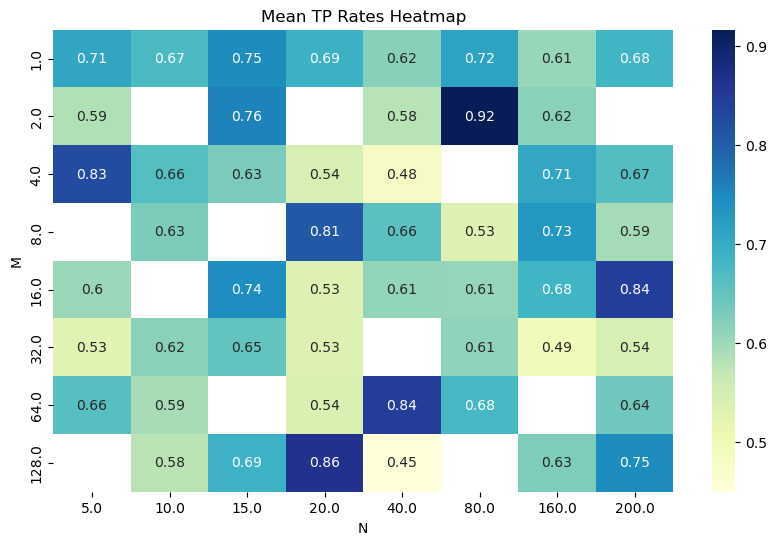

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

tp_mean = tp_stats.reset_index().pivot_table(index='M', columns='N', values='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(tp_mean, annot=True, cmap='YlGnBu')
plt.title('Mean TP Rates Heatmap')
plt.xlabel('N')
plt.ylabel('M')
plt.show()


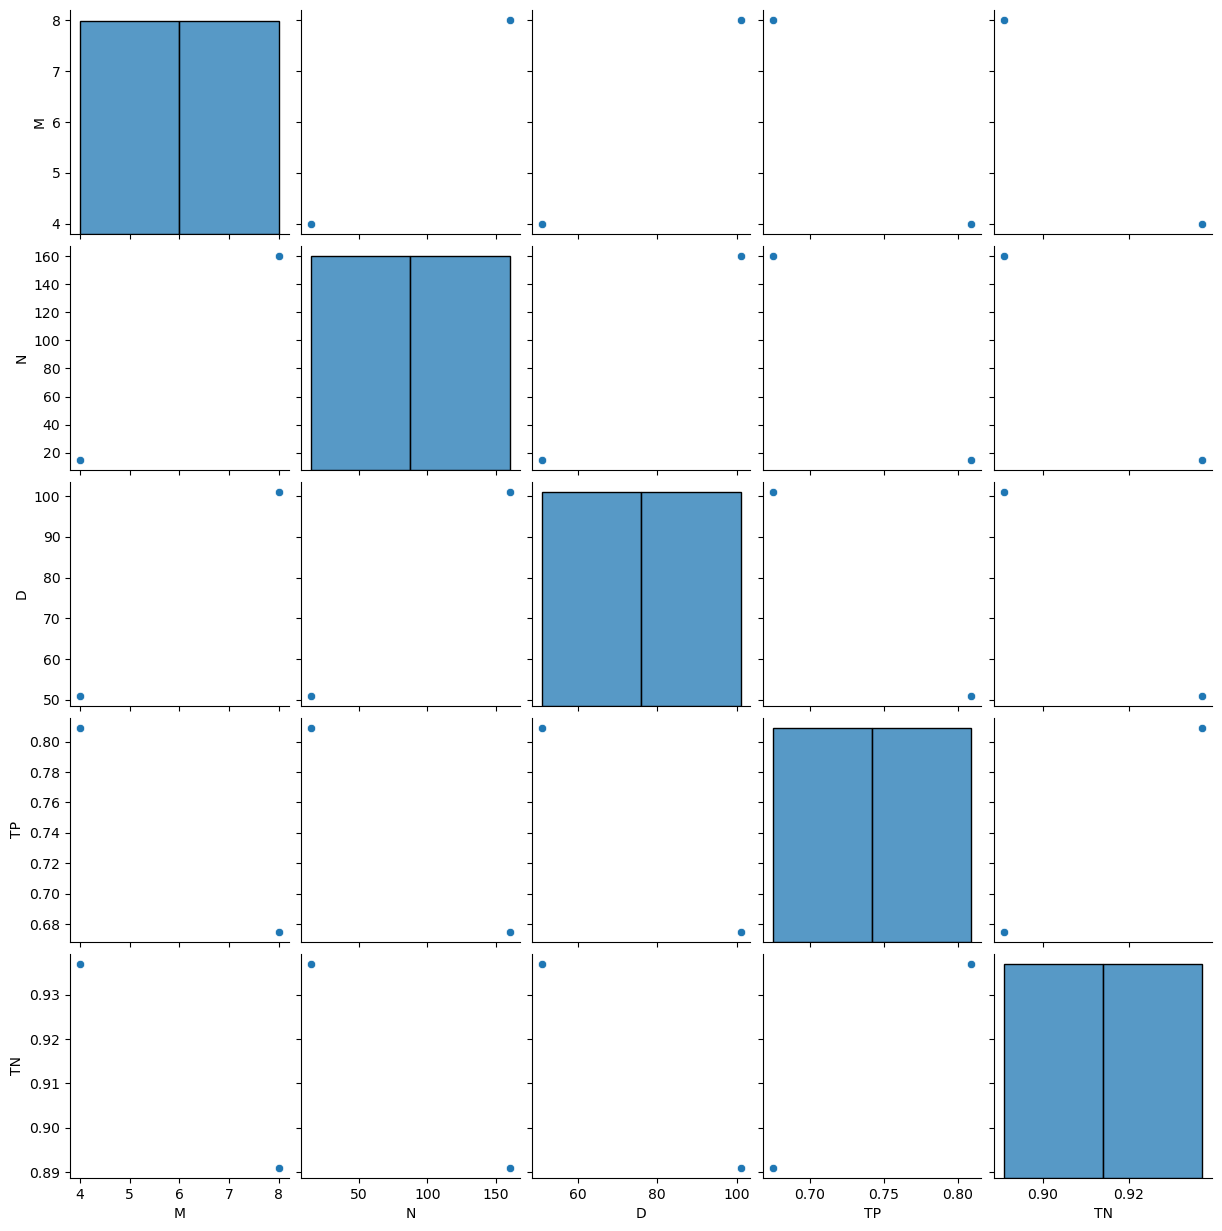

AttributeError: module 'seaborn' has no attribute 'parallel_coordinates'

<Figure size 1000x600 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data into a list of dictionaries (similar to your 'results' list)
results = [
    {'idc': 659218, 'M': 4.0, 'N': 15.0, 'D': 51.0, 'TP': 0.809, 'TN': 0.937},
    {'idc': 541278, 'M': 8.0, 'N': 160.0, 'D': 101.0, 'TP': 0.675, 'TN': 0.891},
    # ... more data points ...
]

# Convert the list of dictionaries to a DataFrame for easier plotting
import pandas as pd
df = pd.DataFrame(results)

# Pair Plot (Scatter Plot Matrix)
sns.pairplot(df, vars=['M', 'N', 'D', 'TP', 'TN'])
plt.show()

# Parallel Coordinates Plot
plt.figure(figsize=(10, 6))
sns.parallel_coordinates(df, class_column='TP')
plt.show()

# Heatmap
plt.figure(figsize=(10, 6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Bar Chart for Average TP and TN Rates by 'M'
plt.figure(figsize=(10, 6))
sns.barplot(x='M', y='TP', data=df)
plt.title('Average TP Rate by M')
plt.show()

# Violin Plot for TP and TN Rates across 'N'
plt.figure(figsize=(10, 6))
sns.violinplot(x='N', y='TP', data=df, inner='quartile')
plt.title('Distribution of TP Rates across N')
plt.show()

# Pairwise Density Plot for TP and TN Rates
sns.jointplot(x='TP', y='TN', data=df, kind='hex', color='blue')
plt.show()

# Interactive Filtering (using Plotly)
import plotly.express as px
fig = px.scatter(df, x='D', y='TP', color='M', size='TN', hover_name='idc')
fig.show()
